# **SETUP**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Importing libraries**

In [2]:
import tensorflow
print(tensorflow.__version__)

2.8.2


In [3]:
# Import Libraries
import sys

import numpy as np
import random
import pandas as pd
import os
import tensorflow as tf
import pickle
#import keras


from numpy.random import seed
from tensorflow import keras
from keras.models import Sequential,Model
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from tensorflow.keras.layers import BatchNormalization
from keras.utils import np_utils
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Input,concatenate, Bidirectional, SpatialDropout1D, GlobalAveragePooling1D,Reshape,Conv2D, MaxPool2D
from keras.layers import Add, Activation,LayerNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from keras.regularizers import l1, l2

In [40]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras import utils

In [4]:
# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)

# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

# **Load the dataset**

In [49]:
# Testing path
path = "/content/drive/MyDrive/BankTransactionClassifier/"

In [124]:
# Load the files into a Pandas Dataframe
train = pd.read_csv(path+'Train.csv')
test = pd.read_csv(path+'Test.csv')
ss = pd.read_csv(path+'SampleSubmission.csv')

In [123]:
ss.head()

,ID,Bank Charges,Bill-Payments,Cash-Pickup,Cell Phone and Airtime,Cheque-Payment,Deposit,Donations,General Purchases,Insurance,...,Internet and IT Services,Loan Repayment,Merchant-Payment,Money-Transfer,Professional services,Reversal,Salary and wages,Savings and Investments,Shopping,"Transport, Travel, and Logistics"
0,2014-02-28 00:00:00X3000000000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2014-02-28 00:00:00X7500000000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2014-03-08 00:00:00X4500002863,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2014-03-08 00:00:00X6000002863,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2014-03-08 00:00:00X6000005726,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [126]:
testID = test["ID"]

In [51]:
test.head()

,DATE,TRANSACTION DETAILS,Account_NO,CHQ.NO.,WITHDRAWAL AMT,DEPOSIT AMT,BALANCE AMT,ID
0,2014-02-28,NEFT/FDRL401249530/INDIAFORENSIC,84903292,NaN,0.00,15000000.0,30000000.00,2014-02-28 00:00:00X3000000000
1,2014-02-28,NEFT/FDRL401249533/INDIAFORENSIC,84903292,NaN,0.00,15000000.0,75000000.00,2014-02-28 00:00:00X7500000000
2,2014-03-08,RTGSCHARGESANDSTAX/RAT,84903292,NaN,28.63,0.0,45000028.63,2014-03-08 00:00:00X4500002863
3,2014-03-08,RTGS/YESBH16068986176/INDFOR,84903292,NaN,15000000.00,0.0,60000028.63,2014-03-08 00:00:00X6000002863
4,2014-03-08,RTGSCHARGESANDSTAX/RAT,84903292,NaN,28.63,0.0,60000057.26,2014-03-08 00:00:00X6000005726


In [52]:
train.head()

,DATE,TRANSACTION DETAILS,Account_NO,CHQ.NO.,WITHDRAWAL AMT,DEPOSIT AMT,BALANCE AMT,Category
0,2014-02-28,NEFT/FDRL401249529/INDIAFORENSIC,84903292,NaN,0.0,15000000.0,15000000.0,Money-Transfer
1,2014-02-28,NEFT/FDRL401249532/INDIAFORENSIC,84903292,NaN,0.0,15000000.0,60000000.0,Money-Transfer
2,2014-02-28,NEFT/FDRL401249534/INDIAFORENSIC,84903292,NaN,0.0,15000000.0,90000000.0,Money-Transfer
3,2014-02-28,NEFT/FDRL401249590/INDIAFORENSIC,84903292,NaN,0.0,10000000.0,100000000.0,Money-Transfer
4,2014-02-28,NEFT/FDRL401249531/INDIAFORENSIC,84903292,NaN,0.0,15000000.0,45000000.0,Money-Transfer


In [53]:
train.shape, test.shape

((57974, 8), (22625, 8))

In [54]:
selectCol = ["DATE", "TRANSACTION DETAILS", "Account_NO", "WITHDRAWAL AMT", "DEPOSIT AMT", "BALANCE AMT"]
label = ["Category"]

In [55]:
import re
train = train[selectCol + label].dropna()
test = test[selectCol]

train["TRANSACTION DETAILS"] = train["TRANSACTION DETAILS"].apply(lambda x : re.sub(r'\W','',str(x)))
test["TRANSACTION DETAILS"] = test["TRANSACTION DETAILS"].apply(lambda x : re.sub(r'\W','',str(x)))

In [56]:
#train["TRANSACTION DETAILS"] = train["TRANSACTION DETAILS"].apply(lambda x : re.sub(r'\d','',str(x)))
#test["TRANSACTION DETAILS"] = test["TRANSACTION DETAILS"].apply(lambda x : re.sub(r'\d','',str(x)))

In [57]:
train["Sequence_Length"] = train["TRANSACTION DETAILS"].apply(lambda x: len(x))
test["Sequence_Length"] = test["TRANSACTION DETAILS"].apply(lambda x: len(x))

In [58]:
train.head()

,DATE,TRANSACTION DETAILS,Account_NO,WITHDRAWAL AMT,DEPOSIT AMT,BALANCE AMT,Category,Sequence_Length
0,2014-02-28,NEFTFDRL401249529INDIAFORENSIC,84903292,0.0,15000000.0,15000000.0,Money-Transfer,30
1,2014-02-28,NEFTFDRL401249532INDIAFORENSIC,84903292,0.0,15000000.0,60000000.0,Money-Transfer,30
2,2014-02-28,NEFTFDRL401249534INDIAFORENSIC,84903292,0.0,15000000.0,90000000.0,Money-Transfer,30
3,2014-02-28,NEFTFDRL401249590INDIAFORENSIC,84903292,0.0,10000000.0,100000000.0,Money-Transfer,30
4,2014-02-28,NEFTFDRL401249531INDIAFORENSIC,84903292,0.0,15000000.0,45000000.0,Money-Transfer,30


In [59]:
test.head()

,DATE,TRANSACTION DETAILS,Account_NO,WITHDRAWAL AMT,DEPOSIT AMT,BALANCE AMT,Sequence_Length
0,2014-02-28,NEFTFDRL401249530INDIAFORENSIC,84903292,0.00,15000000.0,30000000.00,30
1,2014-02-28,NEFTFDRL401249533INDIAFORENSIC,84903292,0.00,15000000.0,75000000.00,30
2,2014-03-08,RTGSCHARGESANDSTAXRAT,84903292,28.63,0.0,45000028.63,21
3,2014-03-08,RTGSYESBH16068986176INDFOR,84903292,15000000.00,0.0,60000028.63,26
4,2014-03-08,RTGSCHARGESANDSTAXRAT,84903292,28.63,0.0,60000057.26,21


In [60]:
train["TRANSACTION DETAILS"].apply(lambda x: len(x)).min(), train["TRANSACTION DETAILS"].apply(lambda x: len(x)).max(), test["TRANSACTION DETAILS"].apply(lambda x: len(x)).min(), test["TRANSACTION DETAILS"].apply(lambda x: len(x)).max()

(5, 31, 8, 30)

In [61]:
train["Account_NO"].value_counts()

20179201    23339
56986993     9739
84903292     7371
80157410     6577
4969373      4013
28039243     2288
10908140      550
83234289      496
68304903      172
22937010        7
Name: Account_NO, dtype: int64

In [62]:
test["Account_NO"].value_counts()

20179201    8900
84903292    4825
56986993    4198
80157410    1793
4969373     1361
28039243    1036
10908140     224
83234289     205
68304903      66
22937010      17
Name: Account_NO, dtype: int64

In [63]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54552 entries, 0 to 57973
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   DATE                 54552 non-null  object 
 1   TRANSACTION DETAILS  54552 non-null  object 
 2   Account_NO           54552 non-null  int64  
 3   WITHDRAWAL AMT       54552 non-null  float64
 4   DEPOSIT AMT          54552 non-null  float64
 5   BALANCE AMT          54552 non-null  float64
 6   Category             54552 non-null  object 
 7   Sequence_Length      54552 non-null  int64  
dtypes: float64(3), int64(2), object(3)
memory usage: 3.7+ MB


In [64]:
train["train"] = 1
test["train"] = 0

data = pd.concat([train, test], axis = 0)

In [65]:
data.head()

,DATE,TRANSACTION DETAILS,Account_NO,WITHDRAWAL AMT,DEPOSIT AMT,BALANCE AMT,Category,Sequence_Length,train
0,2014-02-28,NEFTFDRL401249529INDIAFORENSIC,84903292,0.0,15000000.0,15000000.0,Money-Transfer,30,1
1,2014-02-28,NEFTFDRL401249532INDIAFORENSIC,84903292,0.0,15000000.0,60000000.0,Money-Transfer,30,1
2,2014-02-28,NEFTFDRL401249534INDIAFORENSIC,84903292,0.0,15000000.0,90000000.0,Money-Transfer,30,1
3,2014-02-28,NEFTFDRL401249590INDIAFORENSIC,84903292,0.0,10000000.0,100000000.0,Money-Transfer,30,1
4,2014-02-28,NEFTFDRL401249531INDIAFORENSIC,84903292,0.0,15000000.0,45000000.0,Money-Transfer,30,1


In [66]:
data.shape

(77177, 9)

In [67]:
unique_classes = data.Category.unique()
print("Number of Classes: ", len(unique_classes))
unique_classes

Number of Classes:  22


array(['Money-Transfer', 'Salary and wages', 'Bank Charges',
       'Cash-Pickup', 'Cheque-Payment', 'Deposit', 'Merchant-Payment',
       'Reversal', 'Savings and Investments', 'Internet and IT Services',
       'Bill-Payments', 'Shopping', 'Interest',
       'Transport, Travel, and Logistics', 'Insurance',
       'Cell Phone and Airtime', 'Entertainment', 'Professional services',
       'General Purchases', 'Donations', 'Loan Repayment', nan],
      dtype=object)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


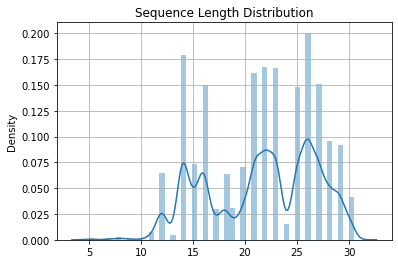

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.distplot(data["Sequence_Length"].values)
plt.title("Sequence Length Distribution")
plt.grid(True)


In [69]:
categories = train.Category.astype('category').cat
class_names = categories.categories
class_codes = categories.codes
num_classes = len(class_names)
print(class_names)

Index(['Bank Charges', 'Bill-Payments', 'Cash-Pickup',
       'Cell Phone and Airtime', 'Cheque-Payment', 'Deposit', 'Donations',
       'Entertainment', 'General Purchases', 'Insurance', 'Interest',
       'Internet and IT Services', 'Loan Repayment', 'Merchant-Payment',
       'Money-Transfer', 'Professional services', 'Reversal',
       'Salary and wages', 'Savings and Investments', 'Shopping',
       'Transport, Travel, and Logistics'],
      dtype='object')


In [70]:
len(categories.categories)

21

In [71]:
train  = train.drop(["train"], axis = 1)
test  = test.drop(["train"], axis = 1)

In [72]:
train["Label"] = categories.codes

In [73]:
train.head()

,DATE,TRANSACTION DETAILS,Account_NO,WITHDRAWAL AMT,DEPOSIT AMT,BALANCE AMT,Category,Sequence_Length,Label
0,2014-02-28,NEFTFDRL401249529INDIAFORENSIC,84903292,0.0,15000000.0,15000000.0,Money-Transfer,30,14
1,2014-02-28,NEFTFDRL401249532INDIAFORENSIC,84903292,0.0,15000000.0,60000000.0,Money-Transfer,30,14
2,2014-02-28,NEFTFDRL401249534INDIAFORENSIC,84903292,0.0,15000000.0,90000000.0,Money-Transfer,30,14
3,2014-02-28,NEFTFDRL401249590INDIAFORENSIC,84903292,0.0,10000000.0,100000000.0,Money-Transfer,30,14
4,2014-02-28,NEFTFDRL401249531INDIAFORENSIC,84903292,0.0,15000000.0,45000000.0,Money-Transfer,30,14


In [74]:
test.head()

,DATE,TRANSACTION DETAILS,Account_NO,WITHDRAWAL AMT,DEPOSIT AMT,BALANCE AMT,Sequence_Length
0,2014-02-28,NEFTFDRL401249530INDIAFORENSIC,84903292,0.00,15000000.0,30000000.00,30
1,2014-02-28,NEFTFDRL401249533INDIAFORENSIC,84903292,0.00,15000000.0,75000000.00,30
2,2014-03-08,RTGSCHARGESANDSTAXRAT,84903292,28.63,0.0,45000028.63,21
3,2014-03-08,RTGSYESBH16068986176INDFOR,84903292,15000000.00,0.0,60000028.63,26
4,2014-03-08,RTGSCHARGESANDSTAXRAT,84903292,28.63,0.0,60000057.26,21


In [75]:
# build Tokenizer
tokenizer = tf.keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts(train["TRANSACTION DETAILS"].values.tolist())


# Save Tokenizer
with open(f'{path}tokenizerndr.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [76]:
train['kfold'] = -1
    
train = train.sample(frac=1).reset_index(drop=True)
y = train.Label.values

kf = StratifiedKFold(n_splits=5)
for fold, (train_idx,val_idx) in enumerate(kf.split(X=train, y=y)):
  train.loc[val_idx, 'kfold'] = fold

train.to_csv(f'{path}stratified_5_folds.csv',index=False)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


In [77]:
train.head()

,DATE,TRANSACTION DETAILS,Account_NO,WITHDRAWAL AMT,DEPOSIT AMT,BALANCE AMT,Category,Sequence_Length,Label,kfold
0,2016-02-12,INTERNALFUNDTRANSFERIN,20179201,10000000.0,0.0,1.161150e+10,Money-Transfer,22,14,0
1,2016-10-15,CASHDEPPITAMPURALCT,20179201,0.0,301000.0,3.559165e+10,Deposit,19,5,0
2,2018-07-07,IMPS828417662356FROMOX,20179201,0.0,200000.0,5.670276e+10,Money-Transfer,22,14,0
3,2016-02-01,IMPSIW261020164C,56986993,0.0,51518.9,3.853295e+10,Money-Transfer,16,14,0
4,2017-04-16,INTERNALFUNDTRANSFERIN,80157410,8000000.0,0.0,1.534639e+10,Money-Transfer,22,14,0


In [78]:
train["kfold"].value_counts()

0    10911
1    10911
2    10910
3    10910
4    10910
Name: kfold, dtype: int64

In [96]:
y_train = pd.DataFrame(np_utils.to_categorical(train["Label"]))
y_train["kfold"] = train["kfold"]

In [97]:
y_train.head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,kfold
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0


# **Modelling**

In [104]:
# Fix seed
seed(1)
tf.random.set_seed(seed=2)

EPOCHS = 30
batch_size = 2000 #4096
max_len = 31
lr = 0.001

# Training Function
def train_fold(tokenizer, fold_, train_df, target):

    df = train_df.copy()
    # dataframes for train and val 
    
    train_df = df[df.kfold != fold_].reset_index(drop=True)
    val_df = df[df.kfold == fold_].reset_index(drop=True)

    ytrain_enc = target[target.kfold != fold_].reset_index(drop=True)
    yval_enc = target[target.kfold == fold_].reset_index(drop=True)

    
    #tokenize train and val

    xtrain = tokenizer.texts_to_sequences(train_df["TRANSACTION DETAILS"].values)
    xval = tokenizer.texts_to_sequences(val_df["TRANSACTION DETAILS"].values)

    # pad sequence
    xtrain = tf.keras.preprocessing.sequence.pad_sequences(xtrain,padding='post',truncating='post',maxlen=max_len)
    xval = tf.keras.preprocessing.sequence.pad_sequences(xval,padding='post',truncating='post',maxlen=max_len)

    word_index = tokenizer.word_index

    # printing shapes of train and val 
    print(xtrain.shape)
    print(xval.shape)

    print(ytrain_enc.shape)
    print(yval_enc.shape)

    print(len(word_index))

    # Define Model: Training on TPU
    
    with tpu_strategy.scope():
        
        sequence_input = Input(shape=(max_len,))

        embedding_layer1 = Embedding(input_dim=len(word_index)+1 ,
                                output_dim=128,
                            input_length=max_len)

        x_emb1 = embedding_layer1(sequence_input)
        x = SpatialDropout1D(0.2)(x_emb1)

        x = Bidirectional(GRU(300,return_sequences=True))(x)
        x = Bidirectional(GRU(300,return_sequences=True))(x)
        x = Conv1D(300, kernel_size = 7, padding = "same",activation='relu', kernel_initializer = "he_uniform")(x)
        avg_pool1 = GlobalAveragePooling1D()(x)
        max_pool1 = GlobalMaxPooling1D()(x)     
        
        x = concatenate([avg_pool1, max_pool1])
        x = Dense(1024, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.8)(x)
        preds = Dense(21, activation='softmax')(x)
        
        model = Model(sequence_input, preds)
        

        model.summary()
      
        model.compile(loss='categorical_crossentropy',steps_per_execution = 50,
                      optimizer= tf.keras.optimizers.Adam(learning_rate=lr)
                      ,metrics=['accuracy'])

    # Fit the model with early stopping,save_best and reduce on plateau callbacks
    earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto')
    save_best = ModelCheckpoint(f"{path}model_{fold_}.h5", save_best_only=True, monitor='val_loss', mode='min')
    rl = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, min_delta=1e-4, mode='min')



    outputs = model.fit(xtrain, y=ytrain_enc, batch_size=batch_size, epochs=EPOCHS, 
          verbose=1, validation_data=(xval, yval_enc), callbacks=[earlystop,save_best,rl])
    
    #return tokenizer

In [113]:
# Load saved Tokenizer and start training
with open(f'{path}tokenizerndr.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

for i in range(5):
    fold_ = i
    train_df=train
    target = y_train
    tokenizer = tokenizer

    df = train_df.copy()
    # dataframes for train and val 
    
    train_df = df[df.kfold != fold_].reset_index(drop=True)
    val_df = df[df.kfold == fold_].reset_index(drop=True)

    ytrain_enc = target[target.kfold != fold_].reset_index(drop=True).drop(["kfold"],axis = 1)
    yval_enc = target[target.kfold == fold_].reset_index(drop=True).drop(["kfold"],axis = 1)

    
    #tokenize train and val

    xtrain = tokenizer.texts_to_sequences(train_df["TRANSACTION DETAILS"].values)
    xval = tokenizer.texts_to_sequences(val_df["TRANSACTION DETAILS"].values)

    # pad sequence
    xtrain = tf.keras.preprocessing.sequence.pad_sequences(xtrain,padding='post',truncating='post',maxlen=max_len)
    xval = tf.keras.preprocessing.sequence.pad_sequences(xval,padding='post',truncating='post',maxlen=max_len)

    word_index = tokenizer.word_index

    # printing shapes of train and val 
    print(xtrain.shape)
    print(xval.shape)

    print(ytrain_enc.shape)
    print(yval_enc.shape)

    print(len(word_index))

    # Define Model: Training on TPU
    
    with tpu_strategy.scope():
        
        sequence_input = Input(shape=(max_len,))

        embedding_layer1 = Embedding(input_dim=len(word_index)+1 ,
                                output_dim=128,
                            input_length=max_len)

        x_emb1 = embedding_layer1(sequence_input)
        x = SpatialDropout1D(0.2)(x_emb1)

        x = Bidirectional(GRU(300,return_sequences=True))(x)
        x = Bidirectional(GRU(300,return_sequences=True))(x)
        x = Conv1D(300, kernel_size = 7, padding = "same",activation='relu', kernel_initializer = "he_uniform")(x)
        avg_pool1 = GlobalAveragePooling1D()(x)
        max_pool1 = GlobalMaxPooling1D()(x)     
        
        x = concatenate([avg_pool1, max_pool1])
        x = Dense(1024, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.8)(x)
        preds = Dense(21, activation='softmax')(x)
        
        model = Model(sequence_input, preds)
        

        model.summary()
      
        model.compile(loss='categorical_crossentropy',steps_per_execution = 50,
                      optimizer= tf.keras.optimizers.Adam(learning_rate=lr)
                      ,metrics=['accuracy'])

    # Fit the model with early stopping,save_best and reduce on plateau callbacks
    earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto')
    save_best = ModelCheckpoint(f"{path}model_{fold_}.h5", save_best_only=True, monitor='val_loss', mode='min')
    rl = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, min_delta=1e-4, mode='min')

    model.fit(xtrain, y=ytrain_enc, batch_size=batch_size, epochs=EPOCHS, 
          verbose=1, validation_data=(xval, yval_enc), callbacks=[earlystop,save_best,rl])

(43641, 31)
(10911, 31)
(43641, 21)
(10911, 21)
37
Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 31)]         0           []                               
                                                                                                  
 embedding_20 (Embedding)       (None, 31, 128)      4864        ['input_21[0][0]']               
                                                                                                  
 spatial_dropout1d_20 (SpatialD  (None, 31, 128)     0           ['embedding_20[0][0]']           
 ropout1D)                                                                                        
                                                                                                  
 bidirectional_40 (Bidirectiona  (None, 

In [114]:
# Inference 

fold = 5
num_classes = 21
# Load Tokenizer
with open(f'{path}tokenizerndr.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

# Load and tokenize test data
test_df = test.copy()

xtest = tokenizer.texts_to_sequences(test_df["TRANSACTION DETAILS"].values)
xtest = tf.keras.preprocessing.sequence.pad_sequences(xtest,padding='post',truncating='post',maxlen=31)
final_preds = []

for i in range(fold):
  loaded_model = tf.keras.models.load_model(f"{path}model_{i}.h5")
  preds = loaded_model.predict(xtest)
  print(preds.shape)
  final_preds.append(preds)

(22625, 21)
(22625, 21)
(22625, 21)
(22625, 21)
(22625, 21)


In [118]:
np.concatenate(final_preds,axis=0).shape

(113125, 21)

In [119]:
pred_0 = np.concatenate(final_preds,axis=0)
print(pred_0.shape)
n_pred = pred_0.reshape(fold,test_df.shape[0],num_classes)
avg = np.mean(n_pred,axis=0)

(113125, 21)


In [120]:
avg.shape

(22625, 21)

In [121]:
pd.DataFrame(avg)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.000001,1.675957e-06,1.035346e-06,7.099446e-07,8.689825e-07,4.412249e-09,1.190125e-06,7.799607e-07,5.293761e-07,4.149006e-07,...,6.840103e-07,1.627742e-06,9.541405e-07,0.999981,8.672455e-07,9.887925e-07,1.744053e-06,7.849286e-07,1.408257e-06,3.478864e-07
1,0.000001,1.344234e-06,7.423992e-07,6.594230e-07,7.476481e-07,3.091709e-09,9.821284e-07,7.006441e-07,4.339610e-07,4.279141e-07,...,6.223982e-07,1.287166e-06,9.897319e-07,0.999983,8.268661e-07,8.587302e-07,1.517538e-06,7.753417e-07,1.105709e-06,3.206252e-07
2,0.999741,1.092551e-05,2.521349e-06,5.239707e-07,1.350192e-06,6.463369e-08,1.024162e-06,3.588134e-06,6.494331e-06,4.723462e-06,...,2.132647e-07,3.351847e-06,9.960284e-05,0.000059,6.018345e-06,4.649802e-05,2.483282e-07,3.574805e-07,1.001179e-07,1.145340e-05
3,0.000003,6.118586e-07,6.616255e-07,7.312173e-07,1.061791e-06,7.674570e-10,5.324988e-07,3.404149e-07,5.581710e-07,3.886636e-07,...,5.431319e-07,5.609813e-07,2.737902e-07,0.999985,1.103538e-06,2.650209e-06,2.129471e-07,4.938565e-07,3.397464e-07,1.863166e-07
4,0.999741,1.092551e-05,2.521349e-06,5.239707e-07,1.350192e-06,6.463369e-08,1.024162e-06,3.588134e-06,6.494331e-06,4.723462e-06,...,2.132647e-07,3.351847e-06,9.960284e-05,0.000059,6.018345e-06,4.649802e-05,2.483282e-07,3.574805e-07,1.001179e-07,1.145340e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22620,0.000006,2.412700e-05,3.164265e-05,5.732818e-06,2.233211e-05,5.835613e-06,4.442324e-06,2.728978e-05,1.359390e-06,6.009689e-06,...,5.113377e-06,1.975526e-05,9.997011e-01,0.000019,4.304710e-06,3.457954e-05,2.126637e-05,4.323291e-06,3.304593e-05,5.233883e-06
22621,0.000006,2.412700e-05,3.164265e-05,5.732816e-06,2.233211e-05,5.835613e-06,4.442324e-06,2.728978e-05,1.359390e-06,6.009689e-06,...,5.113377e-06,1.975526e-05,9.997011e-01,0.000019,4.304710e-06,3.457954e-05,2.126637e-05,4.323291e-06,3.304593e-05,5.233883e-06
22622,0.000006,2.412700e-05,3.164265e-05,5.732818e-06,2.233211e-05,5.835613e-06,4.442324e-06,2.728978e-05,1.359390e-06,6.009689e-06,...,5.113377e-06,1.975526e-05,9.997011e-01,0.000019,4.304710e-06,3.457954e-05,2.126637e-05,4.323291e-06,3.304593e-05,5.233883e-06
22623,0.000013,7.595986e-05,1.526778e-05,2.841673e-06,1.135272e-04,1.063148e-06,7.238092e-06,2.015143e-05,3.253006e-06,3.458092e-06,...,3.972219e-06,5.991399e-05,9.994676e-01,0.000062,8.181711e-06,9.663623e-05,1.062992e-05,4.047463e-06,1.878132e-05,8.730837e-06


In [122]:
y_classes = np.argmax(avg,axis=1)
print(y_classes)

[14 14  0 ... 13 13 13]


In [127]:
submission = pd.DataFrame()
submission["ID"]  = testID
submission[class_names] = avg

In [128]:
submission.head()

,ID,Bank Charges,Bill-Payments,Cash-Pickup,Cell Phone and Airtime,Cheque-Payment,Deposit,Donations,Entertainment,General Purchases,...,Internet and IT Services,Loan Repayment,Merchant-Payment,Money-Transfer,Professional services,Reversal,Salary and wages,Savings and Investments,Shopping,"Transport, Travel, and Logistics"
0,2014-02-28 00:00:00X3000000000,0.000001,1.675957e-06,1.035346e-06,7.099446e-07,8.689825e-07,4.412249e-09,1.190125e-06,7.799607e-07,5.293761e-07,...,6.840103e-07,1.627742e-06,9.541405e-07,0.999981,8.672455e-07,9.887925e-07,1.744053e-06,7.849286e-07,1.408257e-06,3.478864e-07
1,2014-02-28 00:00:00X7500000000,0.000001,1.344234e-06,7.423992e-07,6.594230e-07,7.476481e-07,3.091709e-09,9.821284e-07,7.006441e-07,4.339610e-07,...,6.223982e-07,1.287166e-06,9.897319e-07,0.999983,8.268661e-07,8.587302e-07,1.517538e-06,7.753417e-07,1.105709e-06,3.206252e-07
2,2014-03-08 00:00:00X4500002863,0.999741,1.092551e-05,2.521349e-06,5.239707e-07,1.350192e-06,6.463369e-08,1.024162e-06,3.588134e-06,6.494331e-06,...,2.132647e-07,3.351847e-06,9.960284e-05,0.000059,6.018345e-06,4.649802e-05,2.483282e-07,3.574805e-07,1.001179e-07,1.145340e-05
3,2014-03-08 00:00:00X6000002863,0.000003,6.118586e-07,6.616255e-07,7.312173e-07,1.061791e-06,7.674570e-10,5.324988e-07,3.404149e-07,5.581710e-07,...,5.431319e-07,5.609813e-07,2.737902e-07,0.999985,1.103538e-06,2.650209e-06,2.129471e-07,4.938565e-07,3.397464e-07,1.863166e-07
4,2014-03-08 00:00:00X6000005726,0.999741,1.092551e-05,2.521349e-06,5.239707e-07,1.350192e-06,6.463369e-08,1.024162e-06,3.588134e-06,6.494331e-06,...,2.132647e-07,3.351847e-06,9.960284e-05,0.000059,6.018345e-06,4.649802e-05,2.483282e-07,3.574805e-07,1.001179e-07,1.145340e-05


In [130]:
submission.to_csv("KerasDeepLearning_Solution1.csv", index = False)